4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/10
469/469 [==============================] - 1267s 3s/step - loss: 0.7136 - accuracy: 0.7295 - val_loss: 0.4555 - val_accuracy: 0.8259
Epoch 2/10
469/469 [==============================] - 1021s 2s/step - loss: 0.3930 - accuracy: 0.8557 - val_loss: 0.3553 - val_accuracy: 0.8713
Epoch 3/10
469/469 [==============================] - 984s 2s/step - loss: 0.3094 - accuracy: 0.8857 - val_loss: 0.2834 - val_accuracy: 0.8962
Epoch 4/10
469/469 [==============================] - 995s 2s/step - loss: 0.2598 - accuracy: 0.9043 - val_loss: 0.2698 - val_accuracy: 0.9013
Epoch 5/10
469/469 [==============================] - 980s 2s/step - loss: 0.2259 - accuracy: 0.9171 - val_loss: 0.2369 - val_accuracy: 0.9141
Epoch 6/10
469/469 [==============================] - 982s 2s/step - loss: 0.2027 - accuracy: 0.9263 - val_loss: 0.2320 - val_accuracy: 0.9150
Epoch 7/10
469/469 [==============================] - 984s 2s/step - loss: 0.

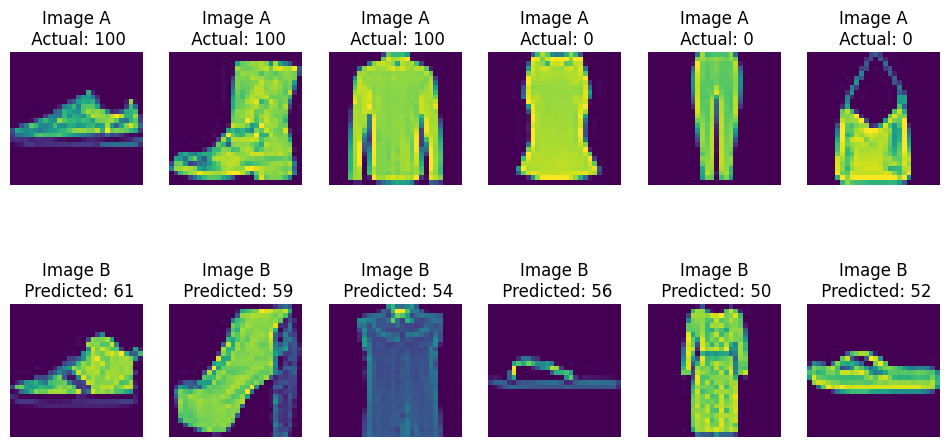

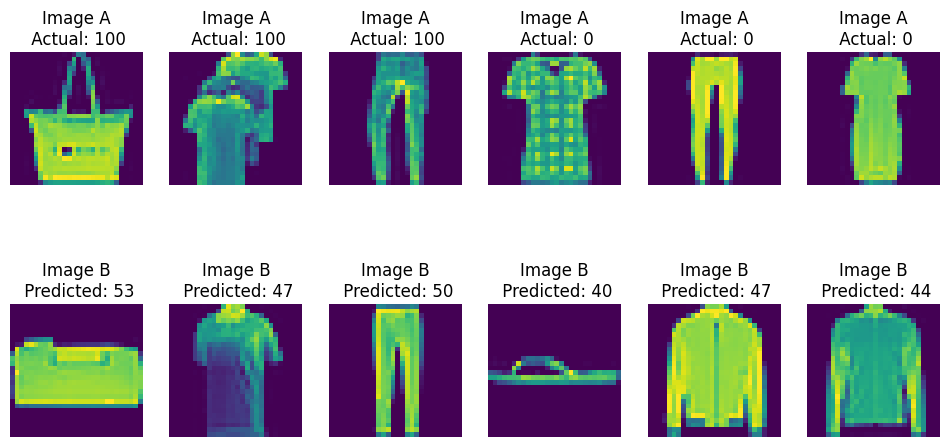

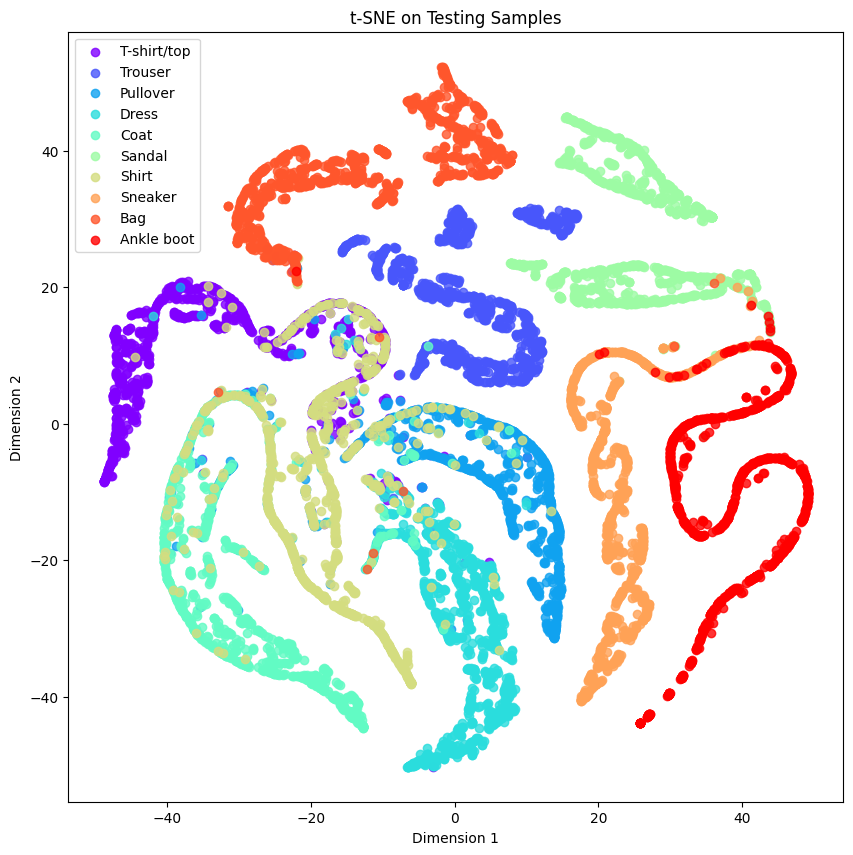

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def inception_v4_block(x, num_filters):
    branch1 = layers.Conv2D(num_filters, kernel_size=1, activation='relu')(x)
    branch2 = layers.Conv2D(num_filters, kernel_size=1, activation='relu')(x)
    branch2 = layers.Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(branch2)
    branch3 = layers.Conv2D(num_filters, kernel_size=1, activation='relu')(x)
    branch3 = layers.Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(branch3)
    branch3 = layers.Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(branch3)
    branch4 = layers.AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(num_filters, kernel_size=1, activation='relu')(branch4)
    x = layers.concatenate([branch1, branch2, branch3, branch4], axis=3)
    return x


input_shape = (28, 28, 1)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, kernel_size=3, activation='relu')(inputs)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = inception_v4_block(x, 64)
x = inception_v4_block(x, 128)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = inception_v4_block(x, 256)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)) / 255.0
test_images = test_images.reshape((10000, 28, 28, 1)) / 255.0
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)


model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels),
          callbacks=[early_stop])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)
model.save('/content/model/saved_model.h5')

from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape=train_images.shape[1:], name='ImageA_Input')
img_b_in = tf.keras.layers.Input(shape=train_images.shape[1:], name='ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name='merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs=[img_a_feat, img_b_feat], outputs=[features], name='Siamese_model')
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
siamese_model.summary()
train_groups = [train_images[np.where(train_labels == i)[0]] for i in np.unique(train_labels)]
test_groups = [test_images[np.where(test_labels == i)[0]] for i in np.unique(train_labels)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])


def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)


def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title(f'Image A\n Actual: {100 * c_d}')
        ax1.axis('off')
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title(f'Image B\n Predicted: {int(100 * p_d[0])}')
        ax2.axis('off')
    return fig


show_model_output()


def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size // 2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
                                 steps_per_epoch=50,
                                 validation_data=([model.predict(valid_a), model.predict(valid_b)],
                                                  valid_sim),
                                 epochs=2,
                                 verbose=True)
show_model_output()

x_test_features = model.predict(test_images, verbose=True, batch_size=128)

tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)
obj_categories = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress',
    'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(test_labels == c_group), 0],
                tsne_features[np.where(test_labels == c_group), 1],
                marker='o',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)